In [1]:
from pathlib import Path
import sys, os
import numpy as np
from pprint import pprint
from copy import deepcopy

# notebook이 examples/selectiveRIP에서 실행 중일 때
repo_root = Path.cwd().resolve().parents[1]  # .../qubit-experiment
sys.path.insert(0, str(repo_root))

In [2]:

from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType
from example_helpers.generate_descriptor import generate_descriptor


descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=3,
    multiplex=True,
    number_multiplex=3,
    include_cr_lines=False,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="withplus",
    ip_address="192.168.0.83"
)




#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:

from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


# Initial QPU

In [4]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


# SAVE QPU

From now on we save/load QPU elements not QuantumElements

In [ ]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "save_test2"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")



# LOAD QPU

Likewise

In [5]:
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits

fuck
LOADED: ./qpu_parameters/20260107-2240_save_test2


# Connection

In [6]:
session = Session(setup)
session.connect(do_emulation=False)

[2026.01.07 22:40:55.201] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.01.07 22:40:55.204] INFO    VERSION: laboneq 25.10.2
[2026.01.07 22:40:55.206] INFO    Connecting to data server at 192.168.0.83:8004
[2026.01.07 22:40:55.247] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.01.07 22:40:55.283] INFO    Configuring the device setup
[2026.01.07 22:40:55.312] INFO    The device setup is configured


In [ ]:
# # Q2 q0 -> q0
# qubits[0].parameters.drive_lo_frequency = 4.0e9
# qubits[0].parameters.drive_range = 10
# qubits[0].parameters.ge_drive_amplitude_pi = 0.6661475528508879
# qubits[0].parameters.ge_drive_amplitude_pi2 = 0.33101490643459497
# qubits[0].parameters.ge_drive_length = 64e-9

# qubits[0].parameters.readout_amplitude = 0.5
# qubits[0].parameters.readout_length = 1.2e-6
# qubits[0].parameters.readout_integration_delay = 400e-9
# qubits[0].parameters.readout_lo_frequency = 7.4e9
# qubits[0].parameters.readout_pulse = {
#             "function": "GaussianSquare",
#             "sigma": 0.2,
#             "risefall_sigma_ratio": 3.0
#         }
# qubits[0].parameters.readout_range_in = 0
# qubits[0].parameters.readout_range_out = 0

# qubits[0].parameters.resonance_frequency_ge = 4124420661.263548
# qubits[0].parameters.resonance_frequency_ef = 4.0e9
# qubits[0].parameters.readout_resonator_frequency = 7558567966.629468
# qubits[0].parameters.reset_delay_length = 100e-6
# qubits[0].parameters.readout_integration_length = 1.2e-6

# # Q3 q1 -> q1
# qubits[1].parameters.drive_lo_frequency = 4.0e9
# qubits[1].parameters.drive_range = 10
# qubits[1].parameters.ge_drive_amplitude_pi = 0.4338709086179622
# qubits[1].parameters.ge_drive_amplitude_pi2 = 0.2157665407686033
# qubits[1].parameters.ge_drive_length = 64e-9

# qubits[1].parameters.readout_amplitude = 0.3
# qubits[1].parameters.readout_length = 1.2e-6
# qubits[1].parameters.readout_integration_delay = 400e-9
# qubits[1].parameters.readout_lo_frequency = 7.4e9
# qubits[1].parameters.readout_pulse = {
#             "function": "GaussianSquare",
#             "sigma": 0.2,
#             "risefall_sigma_ratio": 3.0
#         }
# qubits[1].parameters.readout_range_in = 0
# qubits[1].parameters.readout_range_out = 0

# qubits[1].parameters.resonance_frequency_ge = 3954616948.189805
# qubits[1].parameters.resonance_frequency_ef = 3.8e9
# qubits[1].parameters.readout_resonator_frequency = 7236000000.0
# qubits[1].parameters.reset_delay_length = 100e-6
# qubits[1].parameters.readout_integration_length = 1.2e-6



# # bus mode 1
# buses[0].parameters.resonance_frequency_bus = 5.4947e9
# buses[0].parameters.rip_detuning = -13e6
# buses[0].parameters.drive_lo_frequency = 5.4e9
# # bus mode 2
# buses[1].parameters.resonance_frequency_bus = 5.9687e9
# buses[1].parameters.rip_detuning = -13e6
# buses[1].parameters.drive_lo_frequency = 6.4e9
# # bus mode 3
# buses[2].parameters.resonance_frequency_bus = 6.4203e9
# buses[2].parameters.rip_detuning = -13e6
# buses[2].parameters.drive_lo_frequency = 6.4e9


In [ ]:
from laboneq_applications.experiments import amplitude_rabi
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

# temp_pars.ge_drive_length =64e-9
# temp_pars.drive_range= 10
temp_pars.readout_length = 1.2e-6
temp_pars.readout_integration_length = 1.2e-6
temporary_parameters[q.uid] = temp_pars

#######################################################################
amplitudes = np.linspace(0.0, 1.0,101)
print(q.parameters.ge_drive_amplitude_pi)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters = temporary_parameters
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

# Characterization

In [ ]:
from laboneq_applications.experiments import lifetime_measurement


###############################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_length = 1.6e-6
# temp_pars.readout_integration_length = 1.6e-6
# temp_pars.readout_length = 1.2e-6
# temp_pars.readout_integration_length = 1.2e-6
temporary_parameters[q.uid] = temp_pars


print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = lifetime_measurement.experiment_workflow.options()
options.update(True)
options.count(1024)
# workflow.show_fields(options)
###################################################################
t1 = lifetime_measurement.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    delays = np.linspace(0e-6, 20e-6, 101),
    temporary_parameters = temporary_parameters, 
)

t1_result = t1.run()

# Calibration

## Ramsey 

In [ ]:
from laboneq_applications.experiments import ramsey


q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.resonance_frequency_ge = 4.9528e9
# temp_pars.readout_length = 1.2e-6
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,10e-6,201)
detunings = 0.3e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)

# X90

In [ ]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.do_pca(False)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

# X180

In [ ]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars

#######################################################################
repetitions =np.arange(1,14) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(True)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

# RB

In [ ]:
#from laboneq_applications.experiments import 
from experiments import single_qubit_randomized_benchmarking
q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

#############################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()
options.count(1024)
options.transition("ge")


rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=50,
    options=options,
)

rb_result = rb.run()

#######################################################################

# RIP ECHO

[2026.01.07 22:41:16.925] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.07 22:41:16.925] INFO      Workflow 'rip_echo': execution started at 2026-01-07 13:41:16.924784Z         
[2026.01.07 22:41:16.925] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.07 22:41:16.936] INFO    Task 'temporary_qpu': started at 2026-01-07 13:41:16.936487Z
[2026.01.07 22:41:16.937] INFO    Task 'temporary_qpu': ended at 2026-01-07 13:41:16.937697Z
[2026.01.07 22:41:16.941] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-01-07 
[2026.01.07 22:41:16.941] INFO    13:41:16.940914Z
[2026.01.07 22:41:16.943] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-01-07 13:41:16.942966Z
[2026.01.07 22:41:16.944] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-01-07 
[2026.01.07 22:41:16.944] INFO    13:41:16.944411Z
[2026.01.07 22:41:16.945] INFO    Task 'temporar

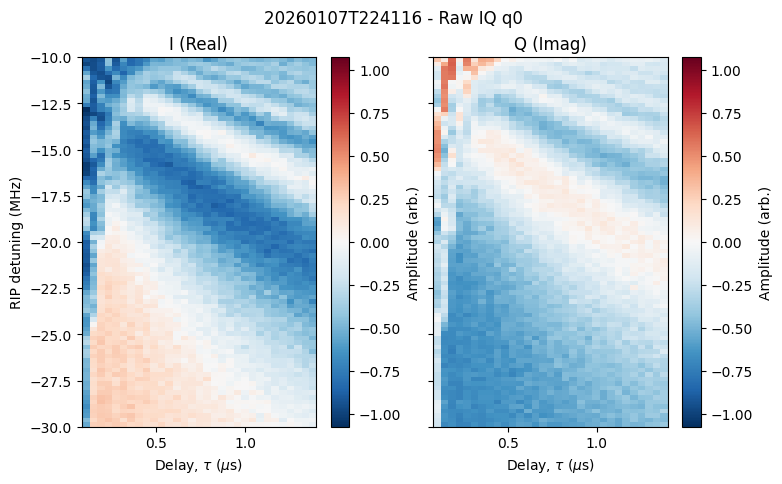

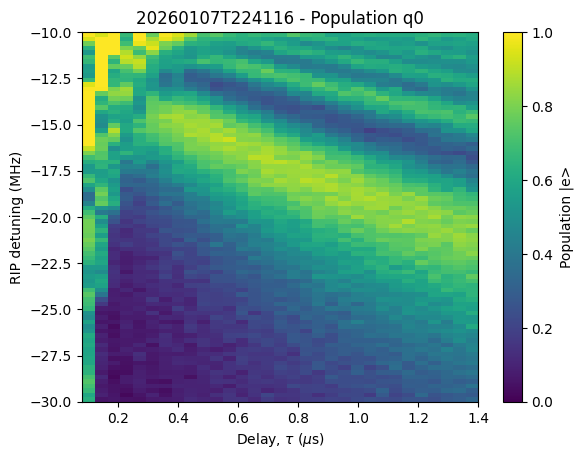

In [7]:
from experiments import new_rip_echo

#q = qubits[1]
#temporary_parameters = q.parameters.copy()

#######################################################################

#######################################################################
options = new_rip_echo.experiment_workflow.options()
options.count(512)
options.update(False)
options.do_analysis(True)

rip_echo = new_rip_echo.experiment_workflow( 
    session=session,
    qpu=qpu,
    ctrl=qubits[1],#Q3
    targ=qubits[0],#Q2  
    bus=buses[0],
    delays=np.linspace(80e-9, 1400e-9, 31),
    rip_detunings=np.linspace(-30e6,-10e6,81),
    ramsey_detunings=0,
    options=options )

rip_echo_result = rip_echo.run()

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_echo_result.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

# Readout opt

In [ ]:
# qubits[1].parameters.readout_integration_delay = 340e-9
# qubits[1].parameters.readout_length = 1.0e-6
# qubits[1].parameters.readout_integration_length = 0.6e-6
# qubits[1].parameters.readout_resonator_frequency = 7.2360e9
# qubits[1].parameters.readout_amplitude = 0.7

In [ ]:
from experiments import iq_traj

####################################################################################
q=qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_length = 1.0e-6
# temp_pars.readout_integration_length = 0.6e-6
# # temp_pars.readout_integration_delay = 0.4e-6
# temp_pars.readout_resonator_frequency = 7.2360e9
# temp_pars.readout_amplitude = 0.7
# temp_pars.readout_range_out = 15

temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
#######################################################################
options = iq_traj.experiment_workflow.options()
options.count(2**14)
options.do_analysis(True)


#print(workflow.show_fields(options))

###################################################################
iq_t = iq_traj.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_traj_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_traj_result.tasks['analysis_workflow'].tasks['plot_iq_trajectories'].output[q.uid]

In [ ]:

from experiments import iq_blobs

#######################################################################
q = qubits[1]

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_length = 1.0e-6
# temp_pars.readout_integration_length = 0.8e-6
# temp_pars.readout_amplitude = 0.7
# temp_pars.readout_integration_delay = 0.4e-6
# temp_pars.readout_resonator_frequency = 7.236e9
# temp_pars.readout_amplitude = 0.7

temporary_parameters[q.uid] = temp_pars
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()
options.count(2**14)
#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)
iq_blob_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_blob_result.tasks['analysis_workflow'].tasks['plot_iq_blobs'].output[q.uid]
print(iq_blob_result.tasks['analysis_workflow'].output)


In [ ]:
qubits[1].parameters.readout_resonator_frequency

# Dispersive Shift

In [ ]:

from experiments import dispersive_shift

#######################################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

#temp_pars.readout_resonator_frequency = 7.5582e9
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(1024)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)